# Fit the linear regression using GridSearchCV

In [1]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from oilproblem.reducing_dimension import delete_constant, variance_filter, corr_y, feature_selection
from oilproblem.aws.oil_config import static_confs
from oilproblem.fit import metrics, plot_fit_metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### definitions

In [2]:
_plot = False
conf = static_confs()
label = 'BP'
_rep_dir = conf['Report'] + "/" + label

### prepare the dataset

In [3]:
df = pd.read_csv(static_confs()['paths']['DATAPREPCSV'])
df = df.set_index(pd.to_datetime(df["raw_date"], format='%Y-%m-%d'))
del df['raw_date']
y = df[label]

### preprocess

In [4]:
df, rep = delete_constant(df, _plot=_plot)
df, rep = variance_filter(df, 0.5, label, plot=_plot, _path=None)
df, rep = corr_y(df, y, _strong=0.9, _plot=_plot, _path=_rep_dir)
df, rep, _ = feature_selection(df, y, _k=20, _plot=_plot, _path=_rep_dir, conf=conf)

# MODELS

### linear regression

In [5]:
model = sklearn.linear_model.LinearRegression()
parameters = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}

### Ridge

In [230]:
model_f = sklearn.linear_model.Ridge
model = model_f()
parameters = {'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
              'normalize': [True, False], 
              'tol': [10e-02, 10e-03, 10e-04, 10e-05, 10e-06], 
              'fit_intercept': [True,False]}

### fit

In [231]:
grid = GridSearchCV(model, parameters, cv=None)
grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 'normalize': [True, False], 'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### grid

In [225]:
res = pd.DataFrame(grid.cv_results_['params'])
sel = list(grid.cv_results_['params'][0].keys())+['mean_test_score',
       'std_test_score', 'rank_test_score', 'mean_train_score',
       'std_train_score']
for key in sel:
    try:
        res[key] = grid.cv_results_[key] 
    except:
        pass
res[sel].sort_values('rank_test_score').head(10)

,fit_intercept,normalize,solver,tol,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
15,True,True,lsqr,0.10000,-1.505694,2.278827,1,0.565434,0.044258
71,False,True,auto,0.01000,-3.247098,2.209198,2,0.744999,0.044399
119,False,False,cholesky,0.00001,-3.247098,2.209198,2,0.744999,0.044399
116,False,False,cholesky,0.01000,-3.247098,2.209198,2,0.744999,0.044399
70,False,True,auto,0.10000,-3.247098,2.209198,2,0.744999,0.044399
115,False,False,cholesky,0.10000,-3.247098,2.209198,2,0.744999,0.044399
109,False,False,auto,0.00001,-3.247098,2.209198,2,0.744999,0.044399
118,False,False,cholesky,0.00010,-3.247098,2.209198,2,0.744999,0.044399
107,False,False,auto,0.00100,-3.247098,2.209198,2,0.744999,0.044399
106,False,False,auto,0.01000,-3.247098,2.209198,2,0.744999,0.044399


# results

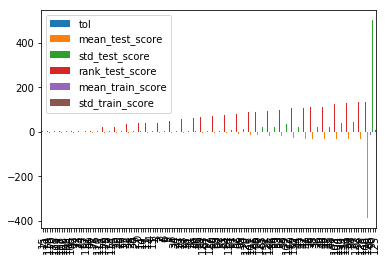

In [226]:
res.sort_values('rank_test_score').plot(kind='bar')
plt.show()

### r^2

In [ ]:
r2 = list()
for par in grid.cv_results_['params']:
    _m = model_f(**par)
    _m.fit(X,y)
    _fit_report = metrics(y, _m.predict(X), _fit_report)
    r2.append(round(_fit_report['r2'],2))

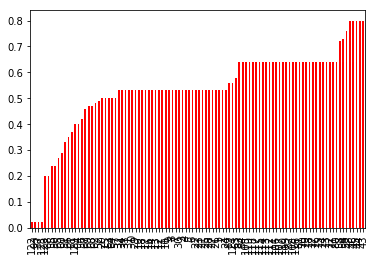

In [254]:
res['r2']=r2
res.sort_values('r2', ascending = False).head()
res[res.r2>0].sort_values('r2').r2.head(100).plot(kind = 'bar', color = 'red')
plt.show()

### fit metrics

In [257]:
grid.best_params_

{'fit_intercept': True, 'normalize': True, 'solver': 'lsqr', 'tol': 0.1}

In [258]:
best = model_f(**grid.best_params_)
best.fit(X,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='lsqr', tol=0.1)

In [260]:
NPERIODS = 3
_fit_report = dict()
_fit_report['model'] = str(model).split("(")[0]
_fit_report['label'] = 'BP'
_fit_report['forecasted_y'] = list(np.insert(best.predict(X[-NPERIODS:]), 0, [y[-(NPERIODS+1)]], axis=0))
_fit_report = metrics(y, best.predict(X), _fit_report)
_fit_report['actual_y'] = list(y[-(NPERIODS+1):])
fit_metrics = _fit_report

### prob plot

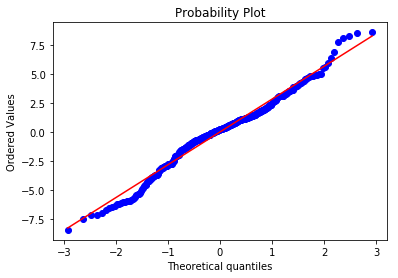

In [261]:
stats.probplot(fit_metrics['y_true'] - np.array(fit_metrics['y_pred']), dist="norm", plot=plt)
plt.show()

### residuals

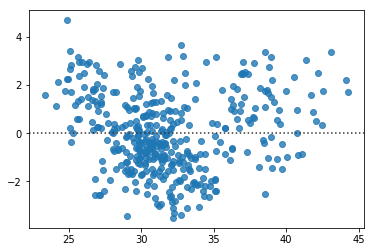

In [262]:
sns.residplot(y_true, y_pred)
plt.show()

### regplot

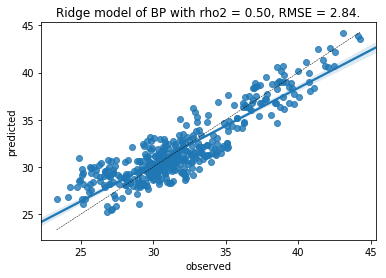

In [263]:
ax = plt.subplot(111)
sns.regplot(y_true, y_pred)
fig = ax.get_figure()

lims = [min(min(y_true), min(y_pred)),  # min of both axes
    max(max(y_true), max(y_pred))]  # max of both axes

plt.xlabel('observed')
plt.ylabel('predicted')
plt.plot(lims,lims, "--", color = 'black', linewidth = 0.5)

plt.title(fit_metrics['model']+" model of {} with rho2 = {:.2f}, RMSE = {:.2f}.".format(
    fit_metrics['label'][:20], fit_metrics['r2'],fit_metrics['rmse']))
plt.show()

### temporal

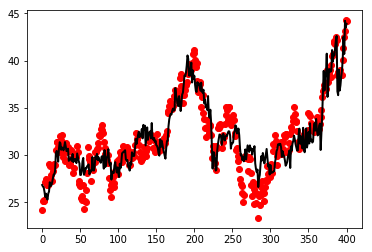

In [264]:
plt.plot(y_true, 'ro')
plt.plot(y_pred, c="black", lw=2)
plt.show()

### forecast

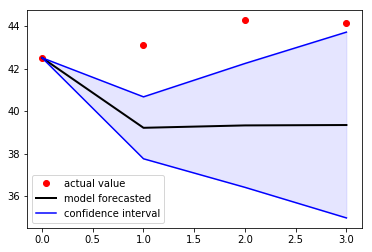

In [265]:
plt.plot(fit_metrics['actual_y'], 'ro', label = 'actual value')
plt.plot(fit_metrics['forecasted_y'], c="black", lw=2, label = 'model forecasted')
plt.fill_between(list(range(NPERIODS+1)), fit_metrics['ci_low'], fit_metrics['ci_high'], color = 'blue', alpha = 0.1)
plt.plot(fit_metrics['ci_low'], c='blue', label= 'confidence interval')
plt.plot(fit_metrics['ci_high'], c='blue')
plt.legend()
plt.show()